<center><img src="https://i.imgur.com/20rO1id.jpg" width="500px"></center>

# Introduction

Hello everyone! Weclome to the "Prostate cANcer graDe Assessment (PANDA) Challenge" competition on Kaggle! In this competition, contestants are challenged to build machine learning models to diagnose Prostate Cancer from biopsy scans (images and masks). This problem is important because fast and accurate automated diagnosis can help reduce burden on doctors and let them focus on curing patients.

In this kernel, I will show how one can build a **multitask model** to solve this problem. I will build a ResNet-based model, which takes a biopsy scan as input and predicts two quantities: the **ISUP grade and  Gleason score**. These are two different, bu related scales used to measure the severity of Prostate Cancer. Training a model on two different, but related tasks **can improve the model's performance on both tasks. This is the magic of multitask learning!**

<font size=3>I will make use of all 8 cores on the TPU v3-8 to train an 8-fold model in less than 1 hour :D</font>


<center><img src="https://i.imgur.com/piOxK6F.png" width="750px"></center>

# Acknowledgements

1. [PyTorch XLA ~ by PyTorch](https://pytorch.org/xla/release/1.5/index.html)
2. [Torchvision Models ~ by PyTorch](https://pytorch.org/docs/stable/torchvision/models.html)
3. [PANDA / submit test ~ Yasufumi Nakama](https://www.kaggle.com/yasufuminakama/panda-submit-test)
4. [Super-duper fast pytorch tpu kernel... ~ by Abhishek](https://www.kaggle.com/abhishek/super-duper-fast-pytorch-tpu-kernel)

# Contents

* [<font size=4>Preparing the ground</font>](#1)
    * [Set up PyTorch-XLA](#1.1)
    * [Import libraries](#1.2)
    * [Set hyperparameters and paths](#1.3)
    * [Load .csv data](#1.4)
    * [Convert Gleason scores to list format](#1.5)
    * [Display few images](#1.6)

    
* [<font size=4>Modeling</font>](#2)
    * [Build PyTorch dataset](#2.1)
    * [Build ResNet model](#2.2)
    * [Visualize ResNet architecture](#2.3)
    * [Split train.csv into 8 folds](#2.4)
    * [Define cross entropy and accuracy](#2.5)
    * [Define custom PANDA loss for multitask model](#2.6)
    * [Define helper function for training logs](#2.7)
    * [Train model on all 8 TPU cores in parallel](#2.8)


* [<font size=4>Takeaways</font>](#3)

# Preparing the ground <a id="1"></a>

## Set up PyTorch-XLA <a id="1.1"></a> <font color="forestgreen" size=4>(inspired by Abhishek's kernel :D)</font>

In [1]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev
!export XLA_USE_BF16=1
!pip install -q torchviz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  26159      0 --:--:-- --:--:-- --:--:-- 26320
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-nightly ...
Found existing installation: torch 1.5.0
Uninstalling torch-1.5.0:
Done updating TPU runtime: <Response [200]>
  Successfully uninstalled torch-1.5.0
Found existing installation: torchvision 0.6.0a0+82fd1c8
Uninstalling torchvision-0.6.0a0+82fd1c8:
  Successfully uninstalled torchvision-0.6.0a0+82fd1c8
Copying gs://tpu-pytorch/wheels/torch-nightly-cp37-cp37m-linux_x86_64.whl...
- [1 files][ 91.7 MiB/ 91.7 MiB]                                                
Operation completed over 1 objects/91.7 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly-cp37-cp37m-linux_x86_64.whl...
- [1 files][122.1 MiB/122.1 MiB]         

## Import libraries <a id="1.2"></a> <font color="forestgreen" size=4>(for data loading, processing, and modeling on TPU)</font>

In [2]:
import os
import gc
import cv2
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage.io import MultiImage
from joblib import Parallel, delayed

from sklearn.utils import shuffle
from colorama import Fore, Back, Style
from keras.utils import to_categorical 

import torch
import torch.nn as nn
from torch.optim import Adam
from torch import LongTensor, FloatTensor
from torch.utils.data import Dataset, DataLoader

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

from torchviz import make_dot

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnext50_32x4d, densenet121, mobilenet_v2
from albumentations import RandomRotate90, Flip, Compose, Normalize, RandomResizedCrop, HorizontalFlip, VerticalFlip, Rotate

Using TensorFlow backend.


In [3]:
np.random.seed(42)
torch.manual_seed(42)

## Set hyperparamerters and paths <a id="1.3"></a> <font color="forestgreen" size=4>(adjust these to improve CV and LB :D)</font>

In [4]:
class config:
    FOLDS = 8
    EPOCHS = 4
    WIDTH = 512
    HEIGHT = 512
    BS = 16
    
    LR = (1e-4, 1e-3)
    MODEL_SAVE_PATH = "resnet_model"
    DATA_PATH = '../input/prostate-cancer-grade-assessment/'
    RESIZED_PATH = '../input/panda-resized-train-data-512x512/train_images/'

In [5]:
TRAIN_IMG_PATH = config.RESIZED_PATH + 'train_images/'
TEST_IMG_PATH = config.DATA_PATH + 'test_images/'

TRAIN_DATA_PATH = config.DATA_PATH + 'train.csv'
TEST_DATA_PATH = config.DATA_PATH + 'test.csv'
SAMPLE_SUB_PATH = config.DATA_PATH + 'sample_submission.csv'

## Load .csv data <a id="1.4"></a> <font color="forestgreen" size=4>(to access image IDs for training and validation)</font>

In [6]:
train_df = pd.read_csv(TRAIN_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)
sub_df = pd.read_csv(SAMPLE_SUB_PATH)

## Convert Gleason scores to list format <a id="1.5"></a> <font color="forestgreen" size=4>(to add them as targets for ResNet)</font>

In [7]:
gleason_replace_dict = {0:0, 1:1, 3:2, 4:3, 5:4}

def process_gleason(gleason):
    if gleason == 'negative': gs = (1, 1)
    else: gs = tuple(gleason.split('+'))
    return [gleason_replace_dict[int(g)] for g in gs]

train_df.gleason_score = train_df.gleason_score.apply(process_gleason)

In [8]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,"[0, 0]"
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,"[0, 0]"
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,"[3, 3]"
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,"[3, 3]"
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,"[0, 0]"


In [9]:
test_df.head()

,image_id,data_provider
0,005700be7e06878e6605e7a5a39de1b2,radboud
1,005c6e8877caf724c600fdce5d417d40,karolinska
2,0104f76634ff89bfff1ef0804a95c380,radboud


## Display few images <a id="1.6"></a> <a id="1.6"></a> <font color="forestgreen" size=4>(from <i>train_images</i> directory)</font>

In [10]:
def display_images(num):
    sq_num = np.sqrt(num)
    assert sq_num == int(sq_num)

    sq_num = int(sq_num)
    fig, ax = plt.subplots(nrows=sq_num, ncols=sq_num, figsize=(20, 20))

    for i in range(int(sq_num)):
        for j in range(int(sq_num)):
            idx = i*sq_num + j
            path = TRAIN_IMG_PATH + train_df.image_id[idx]
    
            path += '.png'
            ax[i, j].imshow(cv2.imread(path))
            ax[i, j].set_title('Image {}'.format(idx), fontsize=12)

    plt.show()

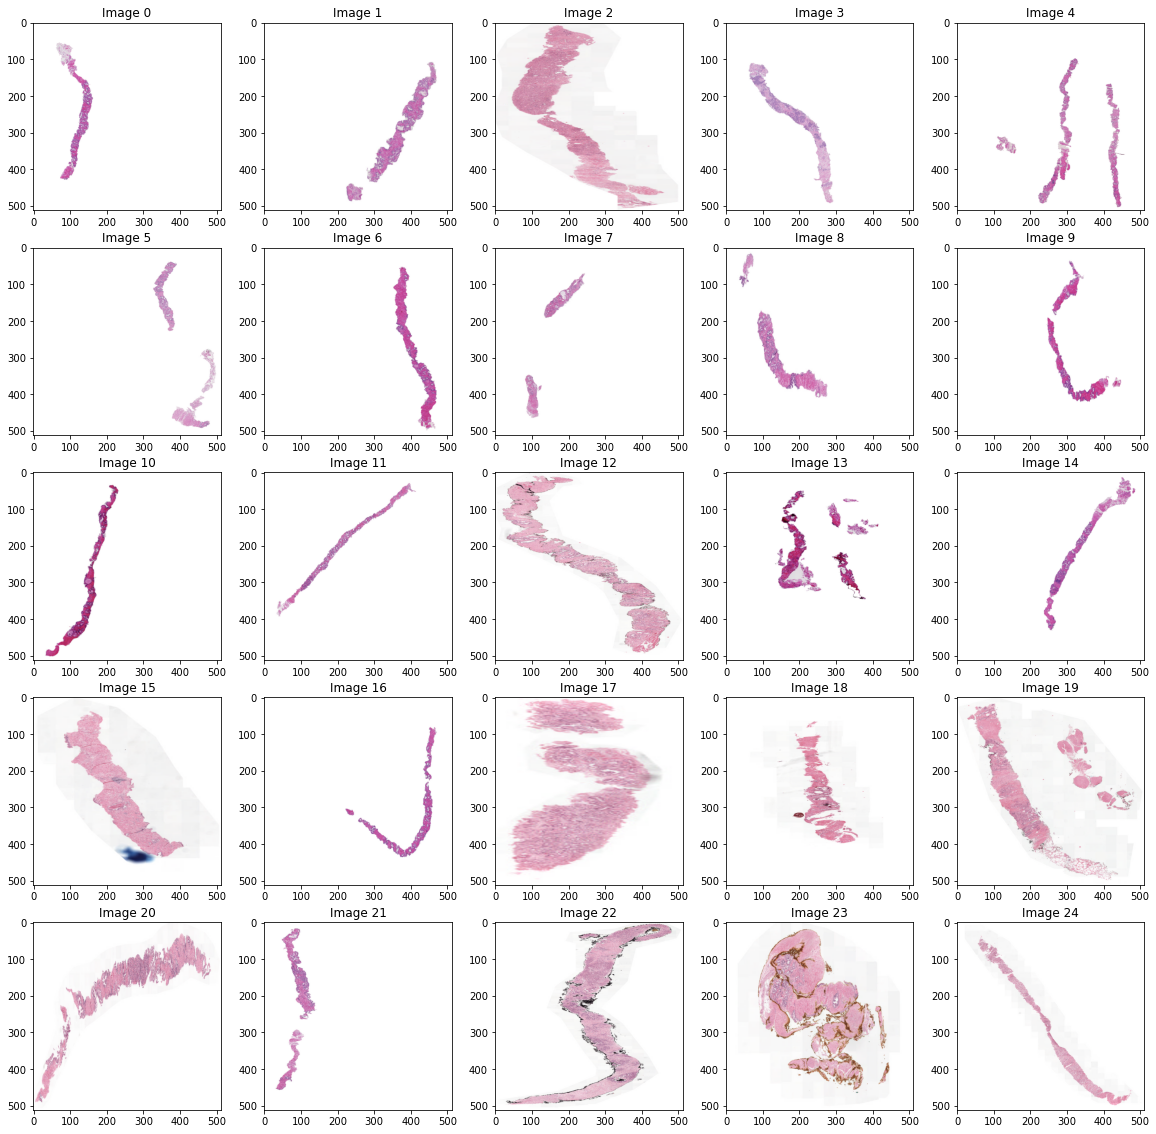

In [11]:
display_images(25)

In [12]:
# trainsform
train_transforms = Compose([HorizontalFlip(p=0.5), 
                            VerticalFlip(p=0.5),
                            Rotate(p=0.5),
                            Normalize()])
val_transforms = Compose([Normalize()])

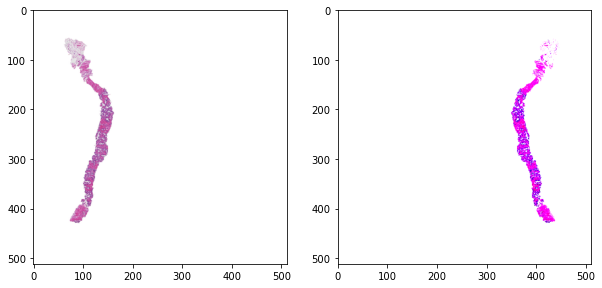

In [13]:
# test
img = TRAIN_IMG_PATH + train_df.image_id[0] + '.png'
img = cv2.imread(img)
al = train_transforms(image=img)['image']
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img); ax[1].imshow(al)

# Modeling <a id="2"></a>

## Build PyTorch dataset <a id="2.1"></a> <font color="forestgreen" size=4>(with image transforms and multi-target)</font>

In [14]:
class PANDADataset(Dataset):
    def __init__(self, df, img_path, split='train'):
        '''
        read resized original image (512, 512, 3) without mask
        data: the df 
        img_path: the directory of images
        '''
        self.df = df
        self.img_path = img_path
        self.split = split

            
    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self, idx):
        path = self.img_path + self.df.image_id[idx] + '.png'
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # aug
        if self.split == 'train':
            img = train_transforms(image=img)['image'].reshape(3, config.HEIGHT, config.WIDTH) # (3, 512, 512)
        else:
            img = val_transforms(image=img)['image'].reshape(3, config.HEIGHT, config.WIDTH) # (3, 512, 512)
            
        # target
        isup_grade = to_categorical([self.df.isup_grade[idx]], num_classes=6) # to one hot (1, 6)
        gleason_0 = to_categorical([self.df.gleason_score[idx][0]], num_classes=5) # (1, 5)
        gleason_1 = to_categorical([self.df.gleason_score[idx][1]], num_classes=5) # (1, 5)
        target = np.concatenate([isup_grade, gleason_0, gleason_1], axis=1) # (1, 16)
        
        return FloatTensor(img), FloatTensor(target) # to tensor
  

Text(0.5, 1.0, 'tensor([[0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]])')

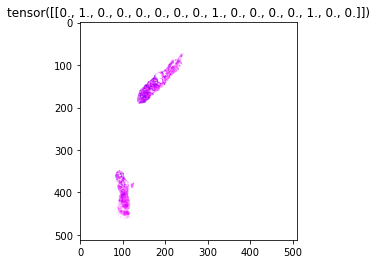

In [20]:
# test dataset
ds = PANDADataset(val_sets[0], TRAIN_IMG_PATH, 'val')
x, y = ds[7]
plt.imshow(x.numpy().reshape(512, 512, 3))
plt.title(y)

## Build ResNet model <a id="2.2"></a> <font color="forestgreen" size=4>(with 3 dense heads for 3 targets)</font>

In [16]:
class ResNetDetector(nn.Module):
    def __init__(self):
        super(ResNetDetector, self).__init__()

        self.resnet = resnext50_32x4d(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1]) # how to disemble network
    
        self.dense_1 = nn.Linear(2048, 6)
        self.dense_2 = nn.Linear(2048, 5)
        self.dense_3 = nn.Linear(2048, 5)
        
        self.softmax = nn.Softmax(dim=1)
        
        
    def forward(self, img):
        feat = self.resnet(img).squeeze() # remove extra 1, (batch, 512)
    
        isup_logit = self.dense_1(feat)
        gleason_logit_0 = self.dense_2(feat)
        gleason_logit_1 = self.dense_3(feat)
        
        isup_prob = self.softmax(isup_logit) # (-1, 6)
        gleason_prob_0 = self.softmax(gleason_logit_0) # (-1, 5)
        gleason_prob_1 = self.softmax(gleason_logit_1) # (-1, 5)
        return torch.cat([isup_prob, gleason_prob_0, gleason_prob_1], axis=1) # (-1, 16)

## Visualize ResNet architecture<a id="2.3"></a> <font color="forestgreen" size=4>(with pytorchviz)</font>

In [17]:
model = ResNetDetector()
x = torch.randn(2, 3, 32, 32).requires_grad_(True)
y = model(x)
print(y.shape)
# make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth



torch.Size([2, 16])


In [18]:
del model, x, y
gc.collect()

54912

## Split train.csv into 8 folds <a id="2.4"></a> <font color="forestgreen" size=4>(for cross-validation)</font>

In [19]:
val_sets, train_sets = [], []
val_splits = np.int32((np.arange(config.FOLDS + 1)/config.FOLDS) * len(train_df))  # divide 8 pieces
val_indices = [[val_splits[i], val_splits[i+1]] for i in range(config.FOLDS)]

for fold in tqdm(range(config.FOLDS)):
    val_idx = val_indices[fold]
    # last fold
#     if fold == FOLDS - 1: val_idx[1] -= 1 # doesn't matter, just 1 entry less
    val_sets.append(train_df[val_idx[0]:val_idx[1]]) # begin:end
    train_sets.append(pd.concat([train_df[:val_idx[0]], train_df[val_idx[1]:]]))

## Define cross entropy and accuracy <a id="2.5"></a> <font color="forestgreen" size=4>(for backpropagation)</font>

In [21]:
def cel(inp, targ):
    '''
    inp: (-1, 6)
    targ: (-1, 6)
    '''
    _, labels = targ.max(dim=1) # value, idx
    return nn.CrossEntropyLoss()(inp, labels)  # (softmax, origin label)

def acc(inp, targ):
    '''
    inp: (-1, 6)
    targ: (-1, 6)
    '''
    inp_idx = inp.max(axis=1).indices
    targ_idx = targ.max(axis=1).indices
    return (inp_idx == targ_idx).float().sum(axis=0)/len(inp_idx)

## Define custom PANDA loss for multitask model <a id="2.6"></a> <font color="forestgreen" size=4>(combining CEL for all three targets)</font>

In [22]:
def panda_cel(inp, targ):
    isup_loss = cel(inp[:, :6], targ[:, :6])
    gleason_loss_0 = cel(inp[:, 6:11], targ[:, 6:11])
    gleason_loss_1 = cel(inp[:, 11:16], targ[:, 11:16])
    return [isup_loss, gleason_loss_0, gleason_loss_1], \
            isup_loss + gleason_loss_0 + gleason_loss_1

def panda_acc(inp, targ):
    '''
    inp (128, 16)
    targ (128, 16)
    '''
    isup_accuracy = acc(inp[:, :6], targ[:, :6])
    gleason_accuracy_0 = acc(inp[:, 6:11], targ[:, 6:11])
    gleason_accuracy_1 = acc(inp[:, 11:16], targ[:, 11:16])
    return [isup_accuracy, gleason_accuracy_0, gleason_accuracy_1]

## Define helper function for training logs <a id="2.7"></a> <font color="forestgreen" size=4>(to check training status)</font>

In [23]:
def print_metric(data, fold, start, end, metric, typ):
    r = Fore.RESET
    n = ["ISUP", "G-0", "G-1"]
    time = np.round(end - start, 1)
    time = "Time: {} s".format(time)
    c = [Fore.CYAN, Fore.YELLOW, Fore.MAGENTA]
    
    tick = Fore.GREEN + '\u2714' + Fore.RESET
    prefix = "FOLD {} ".format(fold + 1) + tick + "  "
    
    string = prefix
    for idx in range(3):
        value = np.round(data[idx].item(), 3)
        t = typ, n[idx], metric, c[idx], value, Fore.RESET
        string = string + "{} {} {}: {}{}{}".format(*t) + "  "
        
    print(string + time)

## Train model on all 8 TPU cores in parallel <a id="2.8"></a> <font color="forestgreen" size=4>(one fold per core)</font>

In [24]:
loss_train_prev = []
acc_train_prev = []

In [25]:
def train(fold):
    # get device
    device = xm.xla_device(fold + 1)
    def xla(tensor):
        return tensor.to(device)
    
    
    # get data
    val = val_sets[fold] # get the val in specific fold
    train = train_sets[fold]

    val = val.reset_index(drop=True)
    val_ds = PANDADataset(val, TRAIN_IMG_PATH, 'val')
    val_dl = DataLoader(val_ds, batch_size=config.BS, shuffle=False)

    train = train.reset_index(drop=True)
    train_ds = PANDADataset(train, TRAIN_IMG_PATH, 'train')
    train_dl = DataLoader(train_ds, batch_size=config.BS, shuffle=True)

    
    # model
    model = xla(ResNetDetector())
    optimizer = Adam([{'params': model.resnet.parameters(), 'lr': config.LR[0]},
                      {'params': model.dense_1.parameters(), 'lr': config.LR[1]},
                      {'params': model.dense_2.parameters(), 'lr': config.LR[1]},
                      {'params': model.dense_3.parameters(), 'lr': config.LR[1]}])

    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True, eps=1e-6)

    
    # train
    start = time.time()
    for epoch in range(config.EPOCHS):

        ## train ----
        model.train()
        for i, (x, y) in tqdm(enumerate(train_dl), total=len(train_dl)):

            # turn device
            model = xla(model)
            x = xla(x) # (128, 3, 512, 512)
            y = xla(y) # (128, 1, 16)

            y_preds = model(x) # softmax (128, 16)

            # metrics
            train_acc = panda_acc(y_preds, y.squeeze())
            train_loss, total_loss = panda_cel(y_preds, y.squeeze())

        
            # update
            optimizer.zero_grad()
            total_loss.backward()
            xm.optimizer_step(optimizer, barrier=True)
            
            xm.master_print('Fold: %d, Epoch: %d, Step: %d, Loss: %2f' % (fold, epoch, i, total_loss.cpu().detach().numpy()))

           
        ## eval ----
        model.eval()
        for x, y in val_dl:
            val_preds, val_targs = [], [] # ?

            with torch.no_grad():
                x = xla(x)
                model = xla(model)
                
                y_preds = model(x)
                val_preds.append(y_preds); val_targs.append(y)
        
        val_preds = torch.cat(val_preds, axis=0)
        val_targs = torch.cat(val_targs, axis=0)
        
        val_targs = xla(val_targs)
        val_acc = panda_acc(val_preds, val_targs.squeeze())
        val_loss, _ = panda_cel(val_preds, val_targs.squeeze())
       
        scheduler.step(val_loss[0])
       
    end = time.time()
    print_metric(val_acc, fold, start, end, metric="acc", typ="Val")
    torch.save(model.state_dict(), MODEL_SAVE_PATH + "_" + str(fold + 1) + ".pth")

In [27]:
Parallel(n_jobs=config.FOLDS, backend="threading")(delayed(train)(i) for i in range(config.FOLDS))

Fold: 4, Epoch: 0, Step: 0, Loss: 5.009801
Fold: 5, Epoch: 0, Step: 0, Loss: 5.005272
Fold: 0, Epoch: 0, Step: 0, Loss: 5.014460
Fold: 3, Epoch: 0, Step: 0, Loss: 5.004412
Fold: 1, Epoch: 0, Step: 0, Loss: 4.997310
Fold: 2, Epoch: 0, Step: 0, Loss: 5.016847
Fold: 7, Epoch: 0, Step: 0, Loss: 5.062248
Fold: 6, Epoch: 0, Step: 0, Loss: 5.009743
Fold: 7, Epoch: 0, Step: 1, Loss: 4.765489
Fold: 4, Epoch: 0, Step: 1, Loss: 4.881774
Fold: 5, Epoch: 0, Step: 1, Loss: 4.954403Fold: 3, Epoch: 0, Step: 1, Loss: 4.922934

Fold: 6, Epoch: 0, Step: 1, Loss: 4.836915
Fold: 2, Epoch: 0, Step: 1, Loss: 4.935524
Fold: 0, Epoch: 0, Step: 1, Loss: 4.816278
Fold: 1, Epoch: 0, Step: 1, Loss: 4.763282
Fold: 6, Epoch: 0, Step: 2, Loss: 4.758455
Fold: 0, Epoch: 0, Step: 2, Loss: 4.750031
Fold: 1, Epoch: 0, Step: 2, Loss: 4.676363
Fold: 4, Epoch: 0, Step: 2, Loss: 4.778821
Fold: 7, Epoch: 0, Step: 2, Loss: 4.856769
Fold: 2, Epoch: 0, Step: 2, Loss: 4.870659
Fold: 3, Epoch: 0, Step: 2, Loss: 4.861224
Fold: 5, Ep

Fold: 4, Epoch: 0, Step: 23, Loss: 4.673815
Fold: 7, Epoch: 0, Step: 22, Loss: 4.948277
Fold: 1, Epoch: 0, Step: 24, Loss: 4.880831
Fold: 5, Epoch: 0, Step: 24, Loss: 4.216708
Fold: 0, Epoch: 0, Step: 24, Loss: 4.680567
Fold: 6, Epoch: 0, Step: 24, Loss: 4.951997
Fold: 2, Epoch: 0, Step: 24, Loss: 4.979047
Fold: 3, Epoch: 0, Step: 24, Loss: 4.615853
Fold: 4, Epoch: 0, Step: 24, Loss: 4.518778
Fold: 7, Epoch: 0, Step: 23, Loss: 4.898206
Fold: 1, Epoch: 0, Step: 25, Loss: 4.847770
Fold: 0, Epoch: 0, Step: 25, Loss: 4.863941
Fold: 5, Epoch: 0, Step: 25, Loss: 4.766973
Fold: 6, Epoch: 0, Step: 25, Loss: 4.825418
Fold: 2, Epoch: 0, Step: 25, Loss: 4.921099
Fold: 3, Epoch: 0, Step: 25, Loss: 4.521178
Fold: 4, Epoch: 0, Step: 25, Loss: 4.882385
Fold: 7, Epoch: 0, Step: 24, Loss: 4.705492
Fold: 1, Epoch: 0, Step: 26, Loss: 4.698534
Fold: 0, Epoch: 0, Step: 26, Loss: 4.796981
Fold: 5, Epoch: 0, Step: 26, Loss: 4.732938
Fold: 6, Epoch: 0, Step: 26, Loss: 4.671021
Fold: 2, Epoch: 0, Step: 26, Los

Fold: 4, Epoch: 0, Step: 46, Loss: 4.789975
Fold: 0, Epoch: 0, Step: 47, Loss: 4.653317
Fold: 3, Epoch: 0, Step: 47, Loss: 4.616713
Fold: 2, Epoch: 0, Step: 47, Loss: 4.499776
Fold: 7, Epoch: 0, Step: 46, Loss: 4.479670
Fold: 6, Epoch: 0, Step: 47, Loss: 5.093612
Fold: 1, Epoch: 0, Step: 48, Loss: 4.389489
Fold: 5, Epoch: 0, Step: 48, Loss: 4.465647
Fold: 4, Epoch: 0, Step: 47, Loss: 4.777152
Fold: 0, Epoch: 0, Step: 48, Loss: 4.702239
Fold: 3, Epoch: 0, Step: 48, Loss: 4.405083
Fold: 2, Epoch: 0, Step: 48, Loss: 4.231896
Fold: 7, Epoch: 0, Step: 47, Loss: 4.586464
Fold: 6, Epoch: 0, Step: 48, Loss: 4.754758
Fold: 1, Epoch: 0, Step: 49, Loss: 4.823281Fold: 5, Epoch: 0, Step: 49, Loss: 4.570878

Fold: 4, Epoch: 0, Step: 48, Loss: 4.758453
Fold: 0, Epoch: 0, Step: 49, Loss: 4.555443
Fold: 3, Epoch: 0, Step: 49, Loss: 4.662100
Fold: 2, Epoch: 0, Step: 49, Loss: 4.584644
Fold: 7, Epoch: 0, Step: 48, Loss: 4.358713
Fold: 6, Epoch: 0, Step: 49, Loss: 4.298390
Fold: 5, Epoch: 0, Step: 50, Los

Fold: 7, Epoch: 0, Step: 69, Loss: 4.669652
Fold: 6, Epoch: 0, Step: 70, Loss: 4.980936
Fold: 5, Epoch: 0, Step: 71, Loss: 4.819766
Fold: 1, Epoch: 0, Step: 71, Loss: 4.332799
Fold: 4, Epoch: 0, Step: 70, Loss: 4.696929
Fold: 3, Epoch: 0, Step: 71, Loss: 4.711038
Fold: 0, Epoch: 0, Step: 71, Loss: 4.783285
Fold: 2, Epoch: 0, Step: 71, Loss: 4.624468
Fold: 7, Epoch: 0, Step: 70, Loss: 4.947712
Fold: 6, Epoch: 0, Step: 71, Loss: 4.779452
Fold: 5, Epoch: 0, Step: 72, Loss: 4.522182
Fold: 1, Epoch: 0, Step: 72, Loss: 4.709088
Fold: 4, Epoch: 0, Step: 71, Loss: 4.740495
Fold: 0, Epoch: 0, Step: 72, Loss: 4.548313
Fold: 2, Epoch: 0, Step: 72, Loss: 4.122297
Fold: 3, Epoch: 0, Step: 72, Loss: 4.780309
Fold: 7, Epoch: 0, Step: 71, Loss: 4.844843
Fold: 6, Epoch: 0, Step: 72, Loss: 4.949071
Fold: 5, Epoch: 0, Step: 73, Loss: 5.010551
Fold: 1, Epoch: 0, Step: 73, Loss: 4.727025
Fold: 4, Epoch: 0, Step: 72, Loss: 4.833567
Fold: 0, Epoch: 0, Step: 73, Loss: 4.610097
Fold: 2, Epoch: 0, Step: 73, Los

Fold: 0, Epoch: 0, Step: 94, Loss: 4.626202
Fold: 4, Epoch: 0, Step: 93, Loss: 4.740027
Fold: 7, Epoch: 0, Step: 93, Loss: 4.688672
Fold: 5, Epoch: 0, Step: 93, Loss: 4.576685
Fold: 1, Epoch: 0, Step: 95, Loss: 4.519622
Fold: 6, Epoch: 0, Step: 94, Loss: 4.232304
Fold: 2, Epoch: 0, Step: 95, Loss: 4.861831
Fold: 3, Epoch: 0, Step: 94, Loss: 4.911429
Fold: 0, Epoch: 0, Step: 95, Loss: 4.509254
Fold: 4, Epoch: 0, Step: 94, Loss: 4.931899
Fold: 7, Epoch: 0, Step: 94, Loss: 4.797632
Fold: 6, Epoch: 0, Step: 95, Loss: 4.505152
Fold: 5, Epoch: 0, Step: 94, Loss: 4.744163
Fold: 1, Epoch: 0, Step: 96, Loss: 5.213354
Fold: 2, Epoch: 0, Step: 96, Loss: 4.448513
Fold: 3, Epoch: 0, Step: 95, Loss: 4.700028
Fold: 0, Epoch: 0, Step: 96, Loss: 4.786823
Fold: 4, Epoch: 0, Step: 95, Loss: 4.657334
Fold: 7, Epoch: 0, Step: 95, Loss: 4.577624
Fold: 6, Epoch: 0, Step: 96, Loss: 4.320857
Fold: 1, Epoch: 0, Step: 97, Loss: 4.547922Fold: 5, Epoch: 0, Step: 95, Loss: 4.553442

Fold: 2, Epoch: 0, Step: 97, Los

Fold: 0, Epoch: 0, Step: 117, Loss: 4.656199
Fold: 4, Epoch: 0, Step: 116, Loss: 4.810174
Fold: 6, Epoch: 0, Step: 117, Loss: 4.800990
Fold: 5, Epoch: 0, Step: 116, Loss: 4.917295
Fold: 2, Epoch: 0, Step: 118, Loss: 4.737353
Fold: 1, Epoch: 0, Step: 118, Loss: 4.609531
Fold: 7, Epoch: 0, Step: 117, Loss: 4.846261
Fold: 3, Epoch: 0, Step: 117, Loss: 4.821841
Fold: 0, Epoch: 0, Step: 118, Loss: 4.753279
Fold: 4, Epoch: 0, Step: 117, Loss: 4.798716
Fold: 6, Epoch: 0, Step: 118, Loss: 4.644331
Fold: 5, Epoch: 0, Step: 117, Loss: 4.846875
Fold: 2, Epoch: 0, Step: 119, Loss: 4.321610
Fold: 1, Epoch: 0, Step: 119, Loss: 4.763633
Fold: 7, Epoch: 0, Step: 118, Loss: 4.749417
Fold: 0, Epoch: 0, Step: 119, Loss: 4.486038
Fold: 4, Epoch: 0, Step: 118, Loss: 4.375713
Fold: 3, Epoch: 0, Step: 118, Loss: 4.526012
Fold: 6, Epoch: 0, Step: 119, Loss: 4.774735
Fold: 5, Epoch: 0, Step: 118, Loss: 4.464428
Fold: 2, Epoch: 0, Step: 120, Loss: 4.369291
Fold: 1, Epoch: 0, Step: 120, Loss: 4.734265
Fold: 7, E

Fold: 4, Epoch: 0, Step: 139, Loss: 4.670788
Fold: 2, Epoch: 0, Step: 140, Loss: 4.661687
Fold: 7, Epoch: 0, Step: 139, Loss: 4.805165
Fold: 6, Epoch: 0, Step: 140, Loss: 4.454150
Fold: 5, Epoch: 0, Step: 139, Loss: 4.685403
Fold: 1, Epoch: 0, Step: 141, Loss: 4.389316
Fold: 0, Epoch: 0, Step: 141, Loss: 4.487939
Fold: 3, Epoch: 0, Step: 140, Loss: 4.606370
Fold: 4, Epoch: 0, Step: 140, Loss: 4.264617
Fold: 2, Epoch: 0, Step: 141, Loss: 4.587313
Fold: 6, Epoch: 0, Step: 141, Loss: 4.229323
Fold: 7, Epoch: 0, Step: 140, Loss: 4.671476
Fold: 5, Epoch: 0, Step: 140, Loss: 4.582957
Fold: 3, Epoch: 0, Step: 141, Loss: 4.269927
Fold: 1, Epoch: 0, Step: 142, Loss: 4.635354
Fold: 0, Epoch: 0, Step: 142, Loss: 4.625881
Fold: 2, Epoch: 0, Step: 142, Loss: 4.672225
Fold: 4, Epoch: 0, Step: 141, Loss: 4.958884
Fold: 6, Epoch: 0, Step: 142, Loss: 4.638906
Fold: 7, Epoch: 0, Step: 141, Loss: 4.689903
Fold: 5, Epoch: 0, Step: 141, Loss: 4.480101
Fold: 3, Epoch: 0, Step: 142, Loss: 4.868313
Fold: 1, E

Fold: 2, Epoch: 0, Step: 163, Loss: 4.548542
Fold: 4, Epoch: 0, Step: 162, Loss: 4.934206
Fold: 0, Epoch: 0, Step: 164, Loss: 4.229463
Fold: 1, Epoch: 0, Step: 164, Loss: 4.440320
Fold: 7, Epoch: 0, Step: 162, Loss: 4.828585
Fold: 5, Epoch: 0, Step: 162, Loss: 4.583266
Fold: 6, Epoch: 0, Step: 164, Loss: 4.596972
Fold: 3, Epoch: 0, Step: 163, Loss: 4.668858
Fold: 2, Epoch: 0, Step: 164, Loss: 4.598185
Fold: 4, Epoch: 0, Step: 163, Loss: 4.750909
Fold: 0, Epoch: 0, Step: 165, Loss: 4.774304
Fold: 1, Epoch: 0, Step: 165, Loss: 4.589577
Fold: 7, Epoch: 0, Step: 163, Loss: 4.812472
Fold: 5, Epoch: 0, Step: 163, Loss: 4.596617
Fold: 6, Epoch: 0, Step: 165, Loss: 4.576615
Fold: 3, Epoch: 0, Step: 164, Loss: 4.437979
Fold: 2, Epoch: 0, Step: 165, Loss: 4.599685
Fold: 4, Epoch: 0, Step: 164, Loss: 5.073837
Fold: 0, Epoch: 0, Step: 166, Loss: 4.771038
Fold: 1, Epoch: 0, Step: 166, Loss: 4.555286
Fold: 7, Epoch: 0, Step: 164, Loss: 4.763585
Fold: 5, Epoch: 0, Step: 164, Loss: 4.524272
Fold: 6, E

Fold: 3, Epoch: 0, Step: 185, Loss: 4.546967
Fold: 0, Epoch: 0, Step: 187, Loss: 4.768442
Fold: 7, Epoch: 0, Step: 185, Loss: 4.788352
Fold: 4, Epoch: 0, Step: 185, Loss: 4.918475
Fold: 5, Epoch: 0, Step: 185, Loss: 5.032098
Fold: 6, Epoch: 0, Step: 187, Loss: 4.641913
Fold: 2, Epoch: 0, Step: 187, Loss: 4.608211
Fold: 1, Epoch: 0, Step: 187, Loss: 4.884815
Fold: 3, Epoch: 0, Step: 186, Loss: 5.056089
Fold: 0, Epoch: 0, Step: 188, Loss: 4.593426
Fold: 7, Epoch: 0, Step: 186, Loss: 4.647425
Fold: 4, Epoch: 0, Step: 186, Loss: 4.610290
Fold: 5, Epoch: 0, Step: 186, Loss: 4.785712
Fold: 6, Epoch: 0, Step: 188, Loss: 4.679363
Fold: 2, Epoch: 0, Step: 188, Loss: 4.819196
Fold: 1, Epoch: 0, Step: 188, Loss: 4.792421
Fold: 3, Epoch: 0, Step: 187, Loss: 4.498178
Fold: 0, Epoch: 0, Step: 189, Loss: 5.039065
Fold: 7, Epoch: 0, Step: 187, Loss: 4.692649
Fold: 4, Epoch: 0, Step: 187, Loss: 3.839214
Fold: 5, Epoch: 0, Step: 187, Loss: 4.477418
Fold: 6, Epoch: 0, Step: 189, Loss: 4.746481
Fold: 2, E

Fold: 3, Epoch: 0, Step: 208, Loss: 4.612978
Fold: 7, Epoch: 0, Step: 208, Loss: 4.855788
Fold: 6, Epoch: 0, Step: 210, Loss: 4.541139
Fold: 5, Epoch: 0, Step: 207, Loss: 4.701438
Fold: 4, Epoch: 0, Step: 208, Loss: 4.016696
Fold: 0, Epoch: 0, Step: 210, Loss: 4.744809
Fold: 2, Epoch: 0, Step: 210, Loss: 4.675560
Fold: 1, Epoch: 0, Step: 210, Loss: 4.745527
Fold: 3, Epoch: 0, Step: 209, Loss: 4.972307
Fold: 7, Epoch: 0, Step: 209, Loss: 4.652793
Fold: 6, Epoch: 0, Step: 211, Loss: 4.904772
Fold: 5, Epoch: 0, Step: 208, Loss: 4.420668
Fold: 4, Epoch: 0, Step: 209, Loss: 4.491586
Fold: 0, Epoch: 0, Step: 211, Loss: 4.516244
Fold: 2, Epoch: 0, Step: 211, Loss: 4.696833
Fold: 1, Epoch: 0, Step: 211, Loss: 4.790463
Fold: 3, Epoch: 0, Step: 210, Loss: 4.137798
Fold: 7, Epoch: 0, Step: 210, Loss: 4.606050
Fold: 6, Epoch: 0, Step: 212, Loss: 4.685479
Fold: 5, Epoch: 0, Step: 209, Loss: 4.559150
Fold: 4, Epoch: 0, Step: 210, Loss: 4.446486
Fold: 0, Epoch: 0, Step: 212, Loss: 4.836442
Fold: 2, E

Fold: 0, Epoch: 0, Step: 233, Loss: 4.505885
Fold: 2, Epoch: 0, Step: 232, Loss: 4.702128
Fold: 7, Epoch: 0, Step: 231, Loss: 4.917113
Fold: 4, Epoch: 0, Step: 231, Loss: 4.623219
Fold: 3, Epoch: 0, Step: 232, Loss: 4.290524
Fold: 5, Epoch: 0, Step: 230, Loss: 4.167032
Fold: 6, Epoch: 0, Step: 234, Loss: 4.271764
Fold: 1, Epoch: 0, Step: 233, Loss: 4.627627
Fold: 0, Epoch: 0, Step: 234, Loss: 4.798234
Fold: 2, Epoch: 0, Step: 233, Loss: 4.590625
Fold: 7, Epoch: 0, Step: 232, Loss: 4.680893
Fold: 4, Epoch: 0, Step: 232, Loss: 4.895617
Fold: 3, Epoch: 0, Step: 233, Loss: 4.561954
Fold: 5, Epoch: 0, Step: 231, Loss: 4.632935
Fold: 1, Epoch: 0, Step: 234, Loss: 4.370917
Fold: 6, Epoch: 0, Step: 235, Loss: 4.462358
Fold: 0, Epoch: 0, Step: 235, Loss: 4.891112
Fold: 2, Epoch: 0, Step: 234, Loss: 4.992033
Fold: 7, Epoch: 0, Step: 233, Loss: 4.606716
Fold: 4, Epoch: 0, Step: 233, Loss: 4.740119
Fold: 3, Epoch: 0, Step: 234, Loss: 4.575927
Fold: 5, Epoch: 0, Step: 232, Loss: 4.804865
Fold: 6, E

Fold: 6, Epoch: 0, Step: 256, Loss: 4.829177
Fold: 2, Epoch: 0, Step: 255, Loss: 4.994820
Fold: 0, Epoch: 0, Step: 256, Loss: 4.373436
Fold: 4, Epoch: 0, Step: 254, Loss: 4.437667
Fold: 7, Epoch: 0, Step: 254, Loss: 4.349733
Fold: 3, Epoch: 0, Step: 255, Loss: 4.504612
Fold: 1, Epoch: 0, Step: 256, Loss: 4.660750
Fold: 5, Epoch: 0, Step: 253, Loss: 4.755634
Fold: 6, Epoch: 0, Step: 257, Loss: 4.680631
Fold: 2, Epoch: 0, Step: 256, Loss: 4.624509
Fold: 0, Epoch: 0, Step: 257, Loss: 4.852140
Fold: 4, Epoch: 0, Step: 255, Loss: 4.775587
Fold: 7, Epoch: 0, Step: 255, Loss: 5.120595
Fold: 1, Epoch: 0, Step: 257, Loss: 4.690280
Fold: 5, Epoch: 0, Step: 254, Loss: 4.747216
Fold: 3, Epoch: 0, Step: 256, Loss: 4.321632
Fold: 2, Epoch: 0, Step: 257, Loss: 4.859176
Fold: 6, Epoch: 0, Step: 258, Loss: 4.809277
Fold: 0, Epoch: 0, Step: 258, Loss: 4.354548
Fold: 4, Epoch: 0, Step: 256, Loss: 5.116049
Fold: 7, Epoch: 0, Step: 256, Loss: 4.512855
Fold: 1, Epoch: 0, Step: 258, Loss: 4.663745
Fold: 3, E

Fold: 6, Epoch: 0, Step: 279, Loss: 4.353461
Fold: 4, Epoch: 0, Step: 277, Loss: 5.244737
Fold: 2, Epoch: 0, Step: 278, Loss: 4.260991
Fold: 7, Epoch: 0, Step: 277, Loss: 4.849874
Fold: 1, Epoch: 0, Step: 279, Loss: 4.441652
Fold: 0, Epoch: 0, Step: 279, Loss: 4.758628
Fold: 5, Epoch: 0, Step: 276, Loss: 4.692461
Fold: 3, Epoch: 0, Step: 278, Loss: 4.813303
Fold: 6, Epoch: 0, Step: 280, Loss: 4.613118
Fold: 2, Epoch: 0, Step: 279, Loss: 5.129817
Fold: 4, Epoch: 0, Step: 278, Loss: 4.675184
Fold: 7, Epoch: 0, Step: 278, Loss: 4.640868
Fold: 1, Epoch: 0, Step: 280, Loss: 4.550894
Fold: 0, Epoch: 0, Step: 280, Loss: 5.081481
Fold: 5, Epoch: 0, Step: 277, Loss: 4.853327
Fold: 3, Epoch: 0, Step: 279, Loss: 4.399511
Fold: 6, Epoch: 0, Step: 281, Loss: 4.558474
Fold: 2, Epoch: 0, Step: 280, Loss: 5.010834
Fold: 7, Epoch: 0, Step: 279, Loss: 4.702031
Fold: 4, Epoch: 0, Step: 279, Loss: 4.407698
Fold: 1, Epoch: 0, Step: 281, Loss: 4.385255
Fold: 0, Epoch: 0, Step: 281, Loss: 4.603211
Fold: 5, E

Fold: 6, Epoch: 0, Step: 302, Loss: 4.669526
Fold: 7, Epoch: 0, Step: 300, Loss: 4.415866
Fold: 3, Epoch: 0, Step: 300, Loss: 4.712460
Fold: 4, Epoch: 0, Step: 300, Loss: 4.729349
Fold: 0, Epoch: 0, Step: 302, Loss: 4.515098
Fold: 1, Epoch: 0, Step: 302, Loss: 4.889749
Fold: 5, Epoch: 0, Step: 299, Loss: 4.502178
Fold: 2, Epoch: 0, Step: 302, Loss: 4.292499
Fold: 6, Epoch: 0, Step: 303, Loss: 4.438895
Fold: 7, Epoch: 0, Step: 301, Loss: 4.957245
Fold: 3, Epoch: 0, Step: 301, Loss: 4.830257
Fold: 4, Epoch: 0, Step: 301, Loss: 4.523124
Fold: 0, Epoch: 0, Step: 303, Loss: 4.607229
Fold: 1, Epoch: 0, Step: 303, Loss: 4.674098
Fold: 5, Epoch: 0, Step: 300, Loss: 4.780245
Fold: 2, Epoch: 0, Step: 303, Loss: 4.805618
Fold: 6, Epoch: 0, Step: 304, Loss: 4.512097
Fold: 7, Epoch: 0, Step: 302, Loss: 4.862828
Fold: 3, Epoch: 0, Step: 302, Loss: 4.502785
Fold: 4, Epoch: 0, Step: 302, Loss: 4.568662
Fold: 1, Epoch: 0, Step: 304, Loss: 4.746854
Fold: 0, Epoch: 0, Step: 304, Loss: 4.569260
Fold: 5, E

Fold: 2, Epoch: 0, Step: 324, Loss: 4.532127
Fold: 7, Epoch: 0, Step: 323, Loss: 4.585883
Fold: 5, Epoch: 0, Step: 321, Loss: 4.589298
Fold: 4, Epoch: 0, Step: 323, Loss: 4.563325
Fold: 0, Epoch: 0, Step: 325, Loss: 4.706996
Fold: 1, Epoch: 0, Step: 325, Loss: 4.481370
Fold: 6, Epoch: 0, Step: 326, Loss: 4.679098
Fold: 3, Epoch: 0, Step: 323, Loss: 4.242909
Fold: 2, Epoch: 0, Step: 325, Loss: 4.640387
Fold: 7, Epoch: 0, Step: 324, Loss: 4.575078
Fold: 5, Epoch: 0, Step: 322, Loss: 4.811405
Fold: 4, Epoch: 0, Step: 324, Loss: 4.997576
Fold: 0, Epoch: 0, Step: 326, Loss: 4.518272
Fold: 1, Epoch: 0, Step: 326, Loss: 4.751685
Fold: 3, Epoch: 0, Step: 324, Loss: 4.617147
Fold: 6, Epoch: 0, Step: 327, Loss: 4.691833
Fold: 2, Epoch: 0, Step: 326, Loss: 4.663197
Fold: 5, Epoch: 0, Step: 323, Loss: 4.635150
Fold: 7, Epoch: 0, Step: 325, Loss: 4.531270
Fold: 4, Epoch: 0, Step: 325, Loss: 4.882678
Fold: 0, Epoch: 0, Step: 327, Loss: 4.612119
Fold: 1, Epoch: 0, Step: 327, Loss: 4.850489
Fold: 3, E

Fold: 5, Epoch: 0, Step: 344, Loss: 4.164507
Fold: 6, Epoch: 0, Step: 348, Loss: 4.599633
Fold: 4, Epoch: 0, Step: 345, Loss: 4.466559
Fold: 7, Epoch: 0, Step: 346, Loss: 4.171268
Fold: 0, Epoch: 0, Step: 348, Loss: 4.879596
Fold: 1, Epoch: 0, Step: 348, Loss: 4.510238
Fold: 2, Epoch: 0, Step: 348, Loss: 4.660281
Fold: 3, Epoch: 0, Step: 346, Loss: 5.018133
Fold: 5, Epoch: 0, Step: 345, Loss: 4.942701
Fold: 6, Epoch: 0, Step: 349, Loss: 4.797672
Fold: 4, Epoch: 0, Step: 346, Loss: 4.170517
Fold: 7, Epoch: 0, Step: 347, Loss: 4.916015
Fold: 0, Epoch: 0, Step: 349, Loss: 4.360752
Fold: 1, Epoch: 0, Step: 349, Loss: 4.653007
Fold: 2, Epoch: 0, Step: 349, Loss: 4.576477
Fold: 3, Epoch: 0, Step: 347, Loss: 4.434351
Fold: 5, Epoch: 0, Step: 346, Loss: 4.722773
Fold: 6, Epoch: 0, Step: 350, Loss: 5.009559
Fold: 4, Epoch: 0, Step: 347, Loss: 4.208024
Fold: 7, Epoch: 0, Step: 348, Loss: 4.128098
Fold: 0, Epoch: 0, Step: 350, Loss: 4.557961
Fold: 1, Epoch: 0, Step: 350, Loss: 4.861009
Fold: 2, E

Fold: 0, Epoch: 0, Step: 371, Loss: 4.846550
Fold: 3, Epoch: 0, Step: 368, Loss: 4.448598
Fold: 5, Epoch: 0, Step: 367, Loss: 4.757501
Fold: 6, Epoch: 0, Step: 372, Loss: 4.710666
Fold: 7, Epoch: 0, Step: 369, Loss: 4.406792
Fold: 1, Epoch: 0, Step: 370, Loss: 4.608149
Fold: 4, Epoch: 0, Step: 368, Loss: 4.304446
Fold: 2, Epoch: 0, Step: 371, Loss: 4.868002
Fold: 0, Epoch: 0, Step: 372, Loss: 5.241059
Fold: 3, Epoch: 0, Step: 369, Loss: 4.825544
Fold: 5, Epoch: 0, Step: 368, Loss: 4.719297
Fold: 6, Epoch: 0, Step: 373, Loss: 5.057954
Fold: 7, Epoch: 0, Step: 370, Loss: 4.442816
Fold: 4, Epoch: 0, Step: 369, Loss: 4.430741
Fold: 2, Epoch: 0, Step: 372, Loss: 4.919157
Fold: 1, Epoch: 0, Step: 371, Loss: 4.556405
Fold: 0, Epoch: 0, Step: 373, Loss: 4.781761
Fold: 3, Epoch: 0, Step: 370, Loss: 4.757549
Fold: 5, Epoch: 0, Step: 369, Loss: 4.803015
Fold: 6, Epoch: 0, Step: 374, Loss: 4.951622
Fold: 7, Epoch: 0, Step: 371, Loss: 5.015999
Fold: 4, Epoch: 0, Step: 370, Loss: 4.340719
Fold: 2, E

Fold: 0, Epoch: 0, Step: 394, Loss: 4.269329
Fold: 5, Epoch: 0, Step: 390, Loss: 4.645324
Fold: 3, Epoch: 0, Step: 391, Loss: 4.602216
Fold: 6, Epoch: 0, Step: 395, Loss: 4.714047
Fold: 1, Epoch: 0, Step: 392, Loss: 5.071065
Fold: 7, Epoch: 0, Step: 392, Loss: 4.592623
Fold: 2, Epoch: 0, Step: 394, Loss: 4.495735
Fold: 4, Epoch: 0, Step: 391, Loss: 5.219510
Fold: 0, Epoch: 0, Step: 395, Loss: 4.309312
Fold: 5, Epoch: 0, Step: 391, Loss: 4.697445
Fold: 3, Epoch: 0, Step: 392, Loss: 4.762003
Fold: 6, Epoch: 0, Step: 396, Loss: 4.393285
Fold: 1, Epoch: 0, Step: 393, Loss: 4.440981
Fold: 7, Epoch: 0, Step: 393, Loss: 4.331309
Fold: 2, Epoch: 0, Step: 395, Loss: 4.300620
Fold: 4, Epoch: 0, Step: 392, Loss: 4.760265
Fold: 0, Epoch: 0, Step: 396, Loss: 4.651230
Fold: 5, Epoch: 0, Step: 392, Loss: 4.874627
Fold: 3, Epoch: 0, Step: 393, Loss: 4.518886
Fold: 6, Epoch: 0, Step: 397, Loss: 4.553745
Fold: 1, Epoch: 0, Step: 394, Loss: 4.595985
Fold: 7, Epoch: 0, Step: 394, Loss: 4.766207
Fold: 2, E

Fold: 3, Epoch: 0, Step: 413, Loss: 4.807004
Fold: 4, Epoch: 0, Step: 413, Loss: 4.825650
Fold: 6, Epoch: 0, Step: 418, Loss: 4.871428
Fold: 1, Epoch: 0, Step: 415, Loss: 4.644931
Fold: 5, Epoch: 0, Step: 413, Loss: 4.675423
Fold: 7, Epoch: 0, Step: 415, Loss: 4.747013
Fold: 2, Epoch: 0, Step: 417, Loss: 5.022912
Fold: 0, Epoch: 0, Step: 418, Loss: 4.433699
Fold: 3, Epoch: 0, Step: 414, Loss: 4.671290
Fold: 6, Epoch: 0, Step: 419, Loss: 4.506613
Fold: 1, Epoch: 0, Step: 416, Loss: 4.740869
Fold: 4, Epoch: 0, Step: 414, Loss: 4.981566
Fold: 5, Epoch: 0, Step: 414, Loss: 4.444266
Fold: 7, Epoch: 0, Step: 416, Loss: 4.363070
Fold: 0, Epoch: 0, Step: 419, Loss: 4.320875
Fold: 2, Epoch: 0, Step: 418, Loss: 4.816558
Fold: 3, Epoch: 0, Step: 415, Loss: 4.674308
Fold: 6, Epoch: 0, Step: 420, Loss: 4.720598
Fold: 1, Epoch: 0, Step: 417, Loss: 4.368981
Fold: 4, Epoch: 0, Step: 415, Loss: 4.621003
Fold: 5, Epoch: 0, Step: 415, Loss: 4.149165
Fold: 7, Epoch: 0, Step: 417, Loss: 4.746497
Fold: 0, E

Fold: 6, Epoch: 0, Step: 441, Loss: 4.636857
Fold: 3, Epoch: 0, Step: 436, Loss: 4.637993
Fold: 4, Epoch: 0, Step: 436, Loss: 4.407456
Fold: 1, Epoch: 0, Step: 438, Loss: 4.492347
Fold: 0, Epoch: 0, Step: 441, Loss: 4.687461
Fold: 2, Epoch: 0, Step: 440, Loss: 4.808388
Fold: 5, Epoch: 0, Step: 436, Loss: 4.048928
Fold: 7, Epoch: 0, Step: 438, Loss: 4.674916
Fold: 6, Epoch: 0, Step: 442, Loss: 4.581683
Fold: 3, Epoch: 0, Step: 437, Loss: 4.517345
Fold: 4, Epoch: 0, Step: 437, Loss: 4.703853
Fold: 1, Epoch: 0, Step: 439, Loss: 5.073660
Fold: 0, Epoch: 0, Step: 442, Loss: 4.496474
Fold: 2, Epoch: 0, Step: 441, Loss: 4.480621
Fold: 5, Epoch: 0, Step: 437, Loss: 4.703957
Fold: 7, Epoch: 0, Step: 439, Loss: 4.671206
Fold: 6, Epoch: 0, Step: 443, Loss: 4.525837
Fold: 3, Epoch: 0, Step: 438, Loss: 4.588584
Fold: 1, Epoch: 0, Step: 440, Loss: 4.870227
Fold: 4, Epoch: 0, Step: 438, Loss: 4.299939
Fold: 0, Epoch: 0, Step: 443, Loss: 4.567008
Fold: 2, Epoch: 0, Step: 442, Loss: 4.840186
Fold: 5, E

Fold: 3, Epoch: 0, Step: 459, Loss: 4.534233
Fold: 4, Epoch: 0, Step: 459, Loss: 4.662786
Fold: 6, Epoch: 0, Step: 464, Loss: 4.755286
Fold: 0, Epoch: 0, Step: 464, Loss: 5.003929
Fold: 1, Epoch: 0, Step: 461, Loss: 4.491396
Fold: 7, Epoch: 0, Step: 461, Loss: 4.656766
Fold: 5, Epoch: 0, Step: 459, Loss: 4.547679
Fold: 2, Epoch: 0, Step: 463, Loss: 4.511846
Fold: 3, Epoch: 0, Step: 460, Loss: 4.571369
Fold: 4, Epoch: 0, Step: 460, Loss: 4.940500
Fold: 6, Epoch: 0, Step: 465, Loss: 4.870178
Fold: 0, Epoch: 0, Step: 465, Loss: 4.778199
Fold: 1, Epoch: 0, Step: 462, Loss: 4.444595
Fold: 7, Epoch: 0, Step: 462, Loss: 4.772485
Fold: 5, Epoch: 0, Step: 460, Loss: 4.359069
Fold: 3, Epoch: 0, Step: 461, Loss: 4.613258
Fold: 4, Epoch: 0, Step: 461, Loss: 4.624993
Fold: 2, Epoch: 0, Step: 464, Loss: 4.495181
Fold: 6, Epoch: 0, Step: 466, Loss: 4.520479
Fold: 0, Epoch: 0, Step: 466, Loss: 4.907075
Fold: 1, Epoch: 0, Step: 463, Loss: 4.935262
Fold: 7, Epoch: 0, Step: 463, Loss: 4.078439
Fold: 5, E

Fold: 2, Epoch: 0, Step: 485, Loss: 4.641906
Fold: 5, Epoch: 0, Step: 481, Loss: 4.613465
Fold: 6, Epoch: 0, Step: 487, Loss: 4.584700
Fold: 1, Epoch: 0, Step: 484, Loss: 4.194245
Fold: 4, Epoch: 0, Step: 482, Loss: 5.004374
Fold: 7, Epoch: 0, Step: 484, Loss: 4.920055
Fold: 3, Epoch: 0, Step: 483, Loss: 4.904044
Fold: 0, Epoch: 0, Step: 487, Loss: 4.699058
Fold: 2, Epoch: 0, Step: 486, Loss: 4.822390
Fold: 5, Epoch: 0, Step: 482, Loss: 4.584064
Fold: 6, Epoch: 0, Step: 488, Loss: 4.674183
Fold: 1, Epoch: 0, Step: 485, Loss: 4.390442
Fold: 7, Epoch: 0, Step: 485, Loss: 4.157611
Fold: 4, Epoch: 0, Step: 483, Loss: 4.923291
Fold: 3, Epoch: 0, Step: 484, Loss: 4.910275
Fold: 0, Epoch: 0, Step: 488, Loss: 4.726749
Fold: 2, Epoch: 0, Step: 487, Loss: 4.487278
Fold: 5, Epoch: 0, Step: 483, Loss: 4.540193
Fold: 6, Epoch: 0, Step: 489, Loss: 4.806648
Fold: 1, Epoch: 0, Step: 486, Loss: 4.687899
Fold: 7, Epoch: 0, Step: 486, Loss: 4.592786
Fold: 3, Epoch: 0, Step: 485, Loss: 4.693049
Fold: 4, E

Fold: 4, Epoch: 0, Step: 504, Loss: 4.677612
Fold: 2, Epoch: 0, Step: 508, Loss: 4.410274
Fold: 1, Epoch: 0, Step: 507, Loss: 4.984729
Fold: 5, Epoch: 0, Step: 504, Loss: 4.776116
Fold: 6, Epoch: 0, Step: 510, Loss: 4.494399
Fold: 3, Epoch: 0, Step: 506, Loss: 4.452117
Fold: 0, Epoch: 0, Step: 510, Loss: 4.978495
Fold: 7, Epoch: 0, Step: 507, Loss: 5.276877
Fold: 2, Epoch: 0, Step: 509, Loss: 4.888338
Fold: 4, Epoch: 0, Step: 505, Loss: 4.737125
Fold: 1, Epoch: 0, Step: 508, Loss: 4.563031
Fold: 5, Epoch: 0, Step: 505, Loss: 4.709825
Fold: 6, Epoch: 0, Step: 511, Loss: 4.690494
Fold: 3, Epoch: 0, Step: 507, Loss: 4.397632
Fold: 0, Epoch: 0, Step: 511, Loss: 4.914239
Fold: 7, Epoch: 0, Step: 508, Loss: 4.493079
Fold: 2, Epoch: 0, Step: 510, Loss: 4.578431
Fold: 4, Epoch: 0, Step: 506, Loss: 4.456894
Fold: 1, Epoch: 0, Step: 509, Loss: 4.710508
Fold: 5, Epoch: 0, Step: 506, Loss: 4.391369
Fold: 3, Epoch: 0, Step: 508, Loss: 4.500466
Fold: 6, Epoch: 0, Step: 512, Loss: 4.466945
Fold: 0, E

Fold: 2, Epoch: 0, Step: 531, Loss: 4.732007
Fold: 4, Epoch: 0, Step: 527, Loss: 4.607641
Fold: 1, Epoch: 0, Step: 530, Loss: 4.753710
Fold: 7, Epoch: 0, Step: 529, Loss: 4.460579
Fold: 5, Epoch: 0, Step: 527, Loss: 4.943018
Fold: 0, Epoch: 0, Step: 533, Loss: 4.397040
Fold: 3, Epoch: 0, Step: 529, Loss: 4.462452
Fold: 6, Epoch: 0, Step: 533, Loss: 4.833089
Fold: 2, Epoch: 0, Step: 532, Loss: 4.405032
Fold: 4, Epoch: 0, Step: 528, Loss: 4.577617
Fold: 1, Epoch: 0, Step: 531, Loss: 4.556843
Fold: 7, Epoch: 0, Step: 530, Loss: 4.727077
Fold: 5, Epoch: 0, Step: 528, Loss: 4.763040
Fold: 0, Epoch: 0, Step: 534, Loss: 4.428647
Fold: 3, Epoch: 0, Step: 530, Loss: 4.680525
Fold: 6, Epoch: 0, Step: 534, Loss: 4.634690
Fold: 2, Epoch: 0, Step: 533, Loss: 4.759526
Fold: 4, Epoch: 0, Step: 529, Loss: 5.057596
Fold: 1, Epoch: 0, Step: 532, Loss: 4.967937
Fold: 7, Epoch: 0, Step: 531, Loss: 4.573810
Fold: 5, Epoch: 0, Step: 529, Loss: 4.710405
Fold: 0, Epoch: 0, Step: 535, Loss: 4.872663
Fold: 3, E

Fold: 5, Epoch: 0, Step: 549, Loss: 4.906685
Fold: 6, Epoch: 0, Step: 556, Loss: 4.489997
Fold: 1, Epoch: 0, Step: 553, Loss: 4.522653
Fold: 4, Epoch: 0, Step: 550, Loss: 4.399027
Fold: 2, Epoch: 0, Step: 554, Loss: 4.505650
Fold: 7, Epoch: 0, Step: 552, Loss: 4.504411
Fold: 3, Epoch: 0, Step: 552, Loss: 4.548948
Fold: 0, Epoch: 0, Step: 556, Loss: 4.712451
Fold: 5, Epoch: 0, Step: 550, Loss: 4.513599
Fold: 6, Epoch: 0, Step: 557, Loss: 4.612411
Fold: 1, Epoch: 0, Step: 554, Loss: 4.565176
Fold: 4, Epoch: 0, Step: 551, Loss: 4.411645
Fold: 2, Epoch: 0, Step: 555, Loss: 4.571642
Fold: 7, Epoch: 0, Step: 553, Loss: 4.242883
Fold: 3, Epoch: 0, Step: 553, Loss: 4.184278
Fold: 0, Epoch: 0, Step: 557, Loss: 4.887349
Fold: 5, Epoch: 0, Step: 551, Loss: 5.130199
Fold: 6, Epoch: 0, Step: 558, Loss: 4.371792
Fold: 1, Epoch: 0, Step: 555, Loss: 4.456340
Fold: 4, Epoch: 0, Step: 552, Loss: 4.325382
Fold: 2, Epoch: 0, Step: 556, Loss: 4.491511
Fold: 0, Epoch: 0, Step: 558, Loss: 4.972983
Fold: 7, E

Fold: 3, Epoch: 0, Step: 574, Loss: 4.769784
Fold: 6, Epoch: 0, Step: 579, Loss: 4.715292
Fold: 1, Epoch: 0, Step: 576, Loss: 4.600381
Fold: 5, Epoch: 0, Step: 572, Loss: 4.625166
Fold: 2, Epoch: 0, Step: 577, Loss: 4.558733
Fold: 4, Epoch: 0, Step: 573, Loss: 4.449178
Fold: 0, Epoch: 0, Step: 579, Loss: 4.601959
Fold: 7, Epoch: 0, Step: 575, Loss: 4.578490
Fold: 3, Epoch: 0, Step: 575, Loss: 4.910348
Fold: 5, Epoch: 0, Step: 573, Loss: 4.536365
Fold: 1, Epoch: 0, Step: 577, Loss: 4.719297
Fold: 2, Epoch: 0, Step: 578, Loss: 4.938982
Fold: 4, Epoch: 0, Step: 574, Loss: 4.523781
Fold: 7, Epoch: 0, Step: 576, Loss: 4.409806
Fold: 3, Epoch: 0, Step: 576, Loss: 4.751099
Fold: 5, Epoch: 0, Step: 574, Loss: 4.651880
Fold: 1, Epoch: 0, Step: 578, Loss: 4.463683
Fold: 2, Epoch: 0, Step: 579, Loss: 4.348975
Fold: 4, Epoch: 0, Step: 575, Loss: 4.531882
Fold: 7, Epoch: 0, Step: 577, Loss: 4.200606
Fold: 3, Epoch: 0, Step: 577, Loss: 4.365569
Fold: 1, Epoch: 0, Step: 579, Loss: 4.675196
Fold: 5, E

Fold: 7, Epoch: 1, Step: 0, Loss: 4.646098
Fold: 6, Epoch: 1, Step: 0, Loss: 4.469633
Fold: 3, Epoch: 1, Step: 0, Loss: 4.420213
Fold: 4, Epoch: 1, Step: 0, Loss: 5.133574
Fold: 2, Epoch: 1, Step: 0, Loss: 4.716384
Fold: 5, Epoch: 1, Step: 0, Loss: 4.379919
Fold: 0, Epoch: 1, Step: 0, Loss: 4.231558Fold: 1, Epoch: 1, Step: 0, Loss: 4.511610

Fold: 3, Epoch: 1, Step: 1, Loss: 4.496945
Fold: 5, Epoch: 1, Step: 1, Loss: 3.890816
Fold: 4, Epoch: 1, Step: 1, Loss: 4.323723
Fold: 7, Epoch: 1, Step: 1, Loss: 4.442617
Fold: 0, Epoch: 1, Step: 1, Loss: 4.695028
Fold: 2, Epoch: 1, Step: 1, Loss: 4.124944
Fold: 6, Epoch: 1, Step: 1, Loss: 4.681304
Fold: 1, Epoch: 1, Step: 1, Loss: 4.532661
Fold: 3, Epoch: 1, Step: 2, Loss: 4.813394
Fold: 5, Epoch: 1, Step: 2, Loss: 4.373482
Fold: 4, Epoch: 1, Step: 2, Loss: 4.545224
Fold: 0, Epoch: 1, Step: 2, Loss: 4.706272
Fold: 1, Epoch: 1, Step: 2, Loss: 4.684797
Fold: 2, Epoch: 1, Step: 2, Loss: 4.418689
Fold: 6, Epoch: 1, Step: 2, Loss: 4.658834
Fold: 7, Ep

Fold: 6, Epoch: 1, Step: 23, Loss: 4.223310
Fold: 2, Epoch: 1, Step: 23, Loss: 4.487929
Fold: 5, Epoch: 1, Step: 24, Loss: 4.718055
Fold: 7, Epoch: 1, Step: 23, Loss: 4.485487
Fold: 4, Epoch: 1, Step: 24, Loss: 4.840210
Fold: 1, Epoch: 1, Step: 24, Loss: 4.337138
Fold: 0, Epoch: 1, Step: 24, Loss: 4.404256
Fold: 3, Epoch: 1, Step: 24, Loss: 4.175881
Fold: 6, Epoch: 1, Step: 24, Loss: 4.825221
Fold: 2, Epoch: 1, Step: 24, Loss: 4.400715
Fold: 7, Epoch: 1, Step: 24, Loss: 4.621865
Fold: 5, Epoch: 1, Step: 25, Loss: 4.438333
Fold: 4, Epoch: 1, Step: 25, Loss: 4.643621
Fold: 3, Epoch: 1, Step: 25, Loss: 4.657007
Fold: 1, Epoch: 1, Step: 25, Loss: 4.649386
Fold: 0, Epoch: 1, Step: 25, Loss: 4.807470
Fold: 6, Epoch: 1, Step: 25, Loss: 4.537792
Fold: 2, Epoch: 1, Step: 25, Loss: 4.503230
Fold: 7, Epoch: 1, Step: 25, Loss: 4.883832
Fold: 5, Epoch: 1, Step: 26, Loss: 4.152763
Fold: 4, Epoch: 1, Step: 26, Loss: 4.640209
Fold: 3, Epoch: 1, Step: 26, Loss: 4.245280
Fold: 0, Epoch: 1, Step: 26, Los

Fold: 0, Epoch: 1, Step: 47, Loss: 4.753062
Fold: 7, Epoch: 1, Step: 46, Loss: 4.352725
Fold: 1, Epoch: 1, Step: 47, Loss: 4.497647
Fold: 6, Epoch: 1, Step: 47, Loss: 4.916981
Fold: 2, Epoch: 1, Step: 47, Loss: 4.779929
Fold: 3, Epoch: 1, Step: 47, Loss: 4.610736
Fold: 4, Epoch: 1, Step: 48, Loss: 4.911461
Fold: 5, Epoch: 1, Step: 48, Loss: 4.479110
Fold: 1, Epoch: 1, Step: 48, Loss: 4.390437
Fold: 7, Epoch: 1, Step: 47, Loss: 4.337248
Fold: 0, Epoch: 1, Step: 48, Loss: 4.460417
Fold: 6, Epoch: 1, Step: 48, Loss: 4.753687
Fold: 3, Epoch: 1, Step: 48, Loss: 4.686458
Fold: 2, Epoch: 1, Step: 48, Loss: 4.615719
Fold: 4, Epoch: 1, Step: 49, Loss: 4.551621
Fold: 5, Epoch: 1, Step: 49, Loss: 3.991277
Fold: 1, Epoch: 1, Step: 49, Loss: 4.545157
Fold: 0, Epoch: 1, Step: 49, Loss: 4.492355
Fold: 7, Epoch: 1, Step: 48, Loss: 4.484536
Fold: 6, Epoch: 1, Step: 49, Loss: 4.553222
Fold: 3, Epoch: 1, Step: 49, Loss: 4.388153
Fold: 2, Epoch: 1, Step: 49, Loss: 4.697938
Fold: 4, Epoch: 1, Step: 50, Los

Fold: 2, Epoch: 1, Step: 70, Loss: 4.461484
Fold: 5, Epoch: 1, Step: 71, Loss: 4.736629
Fold: 1, Epoch: 1, Step: 71, Loss: 4.349250
Fold: 4, Epoch: 1, Step: 71, Loss: 4.944782
Fold: 3, Epoch: 1, Step: 71, Loss: 4.886779
Fold: 6, Epoch: 1, Step: 71, Loss: 4.744737
Fold: 7, Epoch: 1, Step: 70, Loss: 4.594603
Fold: 0, Epoch: 1, Step: 71, Loss: 4.714010
Fold: 2, Epoch: 1, Step: 71, Loss: 4.757211
Fold: 5, Epoch: 1, Step: 72, Loss: 4.706984
Fold: 4, Epoch: 1, Step: 72, Loss: 4.675748
Fold: 3, Epoch: 1, Step: 72, Loss: 4.524425
Fold: 1, Epoch: 1, Step: 72, Loss: 4.653572
Fold: 6, Epoch: 1, Step: 72, Loss: 4.648065
Fold: 7, Epoch: 1, Step: 71, Loss: 4.227332
Fold: 0, Epoch: 1, Step: 72, Loss: 4.426629
Fold: 2, Epoch: 1, Step: 72, Loss: 4.431243
Fold: 5, Epoch: 1, Step: 73, Loss: 4.360052
Fold: 4, Epoch: 1, Step: 73, Loss: 4.735401
Fold: 3, Epoch: 1, Step: 73, Loss: 5.039083
Fold: 1, Epoch: 1, Step: 73, Loss: 4.710729
Fold: 6, Epoch: 1, Step: 73, Loss: 4.741047
Fold: 7, Epoch: 1, Step: 72, Los

Fold: 4, Epoch: 1, Step: 94, Loss: 4.203529
Fold: 6, Epoch: 1, Step: 94, Loss: 4.546790
Fold: 3, Epoch: 1, Step: 94, Loss: 4.411199
Fold: 0, Epoch: 1, Step: 94, Loss: 4.389836
Fold: 2, Epoch: 1, Step: 94, Loss: 4.640315
Fold: 7, Epoch: 1, Step: 93, Loss: 4.421810
Fold: 5, Epoch: 1, Step: 95, Loss: 4.922098
Fold: 1, Epoch: 1, Step: 95, Loss: 4.363064
Fold: 4, Epoch: 1, Step: 95, Loss: 4.631177
Fold: 6, Epoch: 1, Step: 95, Loss: 4.493698
Fold: 3, Epoch: 1, Step: 95, Loss: 4.587457
Fold: 0, Epoch: 1, Step: 95, Loss: 4.649282
Fold: 2, Epoch: 1, Step: 95, Loss: 4.505236
Fold: 7, Epoch: 1, Step: 94, Loss: 4.951914
Fold: 5, Epoch: 1, Step: 96, Loss: 4.463745
Fold: 1, Epoch: 1, Step: 96, Loss: 4.618183
Fold: 4, Epoch: 1, Step: 96, Loss: 4.612370
Fold: 6, Epoch: 1, Step: 96, Loss: 4.232710
Fold: 3, Epoch: 1, Step: 96, Loss: 4.499242
Fold: 0, Epoch: 1, Step: 96, Loss: 4.604080
Fold: 2, Epoch: 1, Step: 96, Loss: 4.568308
Fold: 7, Epoch: 1, Step: 95, Loss: 4.692801
Fold: 5, Epoch: 1, Step: 97, Los

Fold: 5, Epoch: 1, Step: 117, Loss: 4.440965
Fold: 3, Epoch: 1, Step: 117, Loss: 4.568482
Fold: 6, Epoch: 1, Step: 117, Loss: 4.700644
Fold: 7, Epoch: 1, Step: 116, Loss: 4.347354
Fold: 2, Epoch: 1, Step: 117, Loss: 4.432082
Fold: 1, Epoch: 1, Step: 118, Loss: 4.824233
Fold: 0, Epoch: 1, Step: 118, Loss: 4.825178
Fold: 4, Epoch: 1, Step: 118, Loss: 4.858366
Fold: 5, Epoch: 1, Step: 118, Loss: 4.364906
Fold: 3, Epoch: 1, Step: 118, Loss: 4.430574
Fold: 6, Epoch: 1, Step: 118, Loss: 4.300259
Fold: 7, Epoch: 1, Step: 117, Loss: 4.922760
Fold: 2, Epoch: 1, Step: 118, Loss: 4.344565
Fold: 1, Epoch: 1, Step: 119, Loss: 4.556812
Fold: 0, Epoch: 1, Step: 119, Loss: 4.761045
Fold: 4, Epoch: 1, Step: 119, Loss: 4.503716
Fold: 5, Epoch: 1, Step: 119, Loss: 4.451888
Fold: 3, Epoch: 1, Step: 119, Loss: 4.532473
Fold: 6, Epoch: 1, Step: 119, Loss: 4.495467
Fold: 7, Epoch: 1, Step: 118, Loss: 4.092639
Fold: 2, Epoch: 1, Step: 119, Loss: 4.631873
Fold: 1, Epoch: 1, Step: 120, Loss: 4.476490
Fold: 0, E

Fold: 5, Epoch: 1, Step: 140, Loss: 4.384037
Fold: 4, Epoch: 1, Step: 140, Loss: 4.453926
Fold: 3, Epoch: 1, Step: 140, Loss: 4.282460
Fold: 1, Epoch: 1, Step: 141, Loss: 4.211703
Fold: 7, Epoch: 1, Step: 139, Loss: 5.304231
Fold: 6, Epoch: 1, Step: 140, Loss: 4.235322
Fold: 0, Epoch: 1, Step: 141, Loss: 4.683388
Fold: 2, Epoch: 1, Step: 140, Loss: 4.563308
Fold: 5, Epoch: 1, Step: 141, Loss: 4.689952
Fold: 4, Epoch: 1, Step: 141, Loss: 4.768477
Fold: 3, Epoch: 1, Step: 141, Loss: 4.671759
Fold: 1, Epoch: 1, Step: 142, Loss: 4.783475
Fold: 7, Epoch: 1, Step: 140, Loss: 4.288341
Fold: 6, Epoch: 1, Step: 141, Loss: 4.570538
Fold: 0, Epoch: 1, Step: 142, Loss: 4.564415
Fold: 2, Epoch: 1, Step: 141, Loss: 4.675903
Fold: 5, Epoch: 1, Step: 142, Loss: 4.842665
Fold: 4, Epoch: 1, Step: 142, Loss: 4.835593
Fold: 3, Epoch: 1, Step: 142, Loss: 4.790237
Fold: 1, Epoch: 1, Step: 143, Loss: 4.355108
Fold: 7, Epoch: 1, Step: 141, Loss: 4.467031
Fold: 6, Epoch: 1, Step: 142, Loss: 4.857011
Fold: 0, E

Fold: 0, Epoch: 1, Step: 163, Loss: 4.717743
Fold: 1, Epoch: 1, Step: 164, Loss: 4.591486
Fold: 6, Epoch: 1, Step: 162, Loss: 4.507747
Fold: 7, Epoch: 1, Step: 162, Loss: 4.909620
Fold: 5, Epoch: 1, Step: 163, Loss: 4.628673
Fold: 4, Epoch: 1, Step: 164, Loss: 4.778327
Fold: 2, Epoch: 1, Step: 163, Loss: 4.593814
Fold: 3, Epoch: 1, Step: 164, Loss: 4.703116
Fold: 0, Epoch: 1, Step: 164, Loss: 4.358366
Fold: 1, Epoch: 1, Step: 165, Loss: 4.510727
Fold: 6, Epoch: 1, Step: 163, Loss: 4.668067
Fold: 7, Epoch: 1, Step: 163, Loss: 5.136050
Fold: 5, Epoch: 1, Step: 164, Loss: 4.547296
Fold: 4, Epoch: 1, Step: 165, Loss: 4.432635
Fold: 2, Epoch: 1, Step: 164, Loss: 4.599727
Fold: 3, Epoch: 1, Step: 165, Loss: 4.094509
Fold: 0, Epoch: 1, Step: 165, Loss: 4.391205
Fold: 1, Epoch: 1, Step: 166, Loss: 4.347914
Fold: 6, Epoch: 1, Step: 164, Loss: 4.263394
Fold: 7, Epoch: 1, Step: 164, Loss: 4.113256
Fold: 5, Epoch: 1, Step: 165, Loss: 4.621396
Fold: 4, Epoch: 1, Step: 166, Loss: 4.179399
Fold: 2, E

Fold: 0, Epoch: 1, Step: 186, Loss: 5.069979
Fold: 1, Epoch: 1, Step: 187, Loss: 4.898192
Fold: 3, Epoch: 1, Step: 186, Loss: 4.689549
Fold: 6, Epoch: 1, Step: 185, Loss: 4.590761
Fold: 2, Epoch: 1, Step: 186, Loss: 4.301257
Fold: 4, Epoch: 1, Step: 187, Loss: 4.426094
Fold: 7, Epoch: 1, Step: 185, Loss: 4.294795
Fold: 5, Epoch: 1, Step: 186, Loss: 4.394722
Fold: 0, Epoch: 1, Step: 187, Loss: 4.980587
Fold: 1, Epoch: 1, Step: 188, Loss: 4.784855
Fold: 6, Epoch: 1, Step: 186, Loss: 5.057462
Fold: 3, Epoch: 1, Step: 187, Loss: 4.823543
Fold: 2, Epoch: 1, Step: 187, Loss: 4.199331
Fold: 4, Epoch: 1, Step: 188, Loss: 4.566631
Fold: 7, Epoch: 1, Step: 186, Loss: 4.147900
Fold: 5, Epoch: 1, Step: 187, Loss: 4.746932
Fold: 0, Epoch: 1, Step: 188, Loss: 4.849720
Fold: 1, Epoch: 1, Step: 189, Loss: 4.654586
Fold: 6, Epoch: 1, Step: 187, Loss: 4.672472
Fold: 3, Epoch: 1, Step: 188, Loss: 4.429214
Fold: 2, Epoch: 1, Step: 188, Loss: 4.645618
Fold: 4, Epoch: 1, Step: 189, Loss: 4.693841
Fold: 7, E

Fold: 5, Epoch: 1, Step: 208, Loss: 4.699807
Fold: 1, Epoch: 1, Step: 210, Loss: 4.771160
Fold: 0, Epoch: 1, Step: 209, Loss: 4.590574
Fold: 6, Epoch: 1, Step: 208, Loss: 4.764401
Fold: 3, Epoch: 1, Step: 209, Loss: 4.743032
Fold: 2, Epoch: 1, Step: 209, Loss: 4.816492
Fold: 4, Epoch: 1, Step: 210, Loss: 4.516690
Fold: 7, Epoch: 1, Step: 208, Loss: 4.512892
Fold: 1, Epoch: 1, Step: 211, Loss: 4.446577
Fold: 5, Epoch: 1, Step: 209, Loss: 4.310019
Fold: 0, Epoch: 1, Step: 210, Loss: 4.502188
Fold: 6, Epoch: 1, Step: 209, Loss: 4.498821
Fold: 3, Epoch: 1, Step: 210, Loss: 4.548002
Fold: 2, Epoch: 1, Step: 210, Loss: 4.450832
Fold: 7, Epoch: 1, Step: 209, Loss: 4.564921
Fold: 4, Epoch: 1, Step: 211, Loss: 4.385082
Fold: 1, Epoch: 1, Step: 212, Loss: 4.842739
Fold: 5, Epoch: 1, Step: 210, Loss: 4.210413
Fold: 0, Epoch: 1, Step: 211, Loss: 4.371555
Fold: 6, Epoch: 1, Step: 210, Loss: 4.360952
Fold: 3, Epoch: 1, Step: 211, Loss: 4.545576
Fold: 2, Epoch: 1, Step: 211, Loss: 4.260660
Fold: 7, E

Fold: 5, Epoch: 1, Step: 230, Loss: 4.580873
Fold: 3, Epoch: 1, Step: 231, Loss: 4.494075
Fold: 4, Epoch: 1, Step: 232, Loss: 4.544866
Fold: 2, Epoch: 1, Step: 232, Loss: 4.993153
Fold: 1, Epoch: 1, Step: 234, Loss: 4.686450
Fold: 6, Epoch: 1, Step: 232, Loss: 4.309202
Fold: 7, Epoch: 1, Step: 231, Loss: 4.691079
Fold: 0, Epoch: 1, Step: 233, Loss: 4.453706
Fold: 5, Epoch: 1, Step: 231, Loss: 5.041004
Fold: 3, Epoch: 1, Step: 232, Loss: 4.531410
Fold: 4, Epoch: 1, Step: 233, Loss: 4.061890
Fold: 2, Epoch: 1, Step: 233, Loss: 4.734329
Fold: 1, Epoch: 1, Step: 235, Loss: 4.754909
Fold: 6, Epoch: 1, Step: 233, Loss: 4.776489
Fold: 7, Epoch: 1, Step: 232, Loss: 4.506246
Fold: 0, Epoch: 1, Step: 234, Loss: 4.975181
Fold: 5, Epoch: 1, Step: 232, Loss: 4.490325
Fold: 4, Epoch: 1, Step: 234, Loss: 4.726409
Fold: 3, Epoch: 1, Step: 233, Loss: 4.569735
Fold: 2, Epoch: 1, Step: 234, Loss: 4.551767
Fold: 1, Epoch: 1, Step: 236, Loss: 4.446865
Fold: 6, Epoch: 1, Step: 234, Loss: 4.518103
Fold: 7, E

Fold: 2, Epoch: 1, Step: 255, Loss: 4.208068
Fold: 3, Epoch: 1, Step: 254, Loss: 4.563995
Fold: 6, Epoch: 1, Step: 255, Loss: 4.725295
Fold: 4, Epoch: 1, Step: 255, Loss: 4.549321
Fold: 1, Epoch: 1, Step: 257, Loss: 4.509737
Fold: 7, Epoch: 1, Step: 254, Loss: 4.442248
Fold: 0, Epoch: 1, Step: 256, Loss: 4.509776Fold: 5, Epoch: 1, Step: 254, Loss: 4.288581

Fold: 2, Epoch: 1, Step: 256, Loss: 4.583038
Fold: 3, Epoch: 1, Step: 255, Loss: 4.682022
Fold: 6, Epoch: 1, Step: 256, Loss: 4.363637
Fold: 4, Epoch: 1, Step: 256, Loss: 4.529677
Fold: 1, Epoch: 1, Step: 258, Loss: 4.908183
Fold: 7, Epoch: 1, Step: 255, Loss: 4.768640
Fold: 5, Epoch: 1, Step: 255, Loss: 4.238721
Fold: 0, Epoch: 1, Step: 257, Loss: 4.718640
Fold: 2, Epoch: 1, Step: 257, Loss: 4.630665
Fold: 3, Epoch: 1, Step: 256, Loss: 4.696272
Fold: 6, Epoch: 1, Step: 257, Loss: 4.619062
Fold: 4, Epoch: 1, Step: 257, Loss: 4.434011
Fold: 1, Epoch: 1, Step: 259, Loss: 4.589027
Fold: 5, Epoch: 1, Step: 256, Loss: 4.264143
Fold: 0, E

Fold: 6, Epoch: 1, Step: 278, Loss: 4.869250
Fold: 4, Epoch: 1, Step: 278, Loss: 4.505122
Fold: 3, Epoch: 1, Step: 277, Loss: 4.381424
Fold: 0, Epoch: 1, Step: 279, Loss: 4.810784
Fold: 1, Epoch: 1, Step: 280, Loss: 4.596511
Fold: 2, Epoch: 1, Step: 279, Loss: 4.392466
Fold: 7, Epoch: 1, Step: 277, Loss: 4.447752
Fold: 5, Epoch: 1, Step: 277, Loss: 4.929316
Fold: 6, Epoch: 1, Step: 279, Loss: 4.411016
Fold: 4, Epoch: 1, Step: 279, Loss: 4.373384
Fold: 3, Epoch: 1, Step: 278, Loss: 4.566165
Fold: 0, Epoch: 1, Step: 280, Loss: 4.687271
Fold: 1, Epoch: 1, Step: 281, Loss: 4.761882
Fold: 2, Epoch: 1, Step: 280, Loss: 4.679775
Fold: 7, Epoch: 1, Step: 278, Loss: 4.663109
Fold: 5, Epoch: 1, Step: 278, Loss: 4.470578
Fold: 4, Epoch: 1, Step: 280, Loss: 4.574715
Fold: 6, Epoch: 1, Step: 280, Loss: 4.795249
Fold: 3, Epoch: 1, Step: 279, Loss: 4.092739
Fold: 0, Epoch: 1, Step: 281, Loss: 4.361945
Fold: 1, Epoch: 1, Step: 282, Loss: 4.835297
Fold: 2, Epoch: 1, Step: 281, Loss: 4.478617
Fold: 7, E

Fold: 4, Epoch: 1, Step: 301, Loss: 4.320588
Fold: 3, Epoch: 1, Step: 300, Loss: 4.247885
Fold: 6, Epoch: 1, Step: 301, Loss: 4.528623
Fold: 5, Epoch: 1, Step: 299, Loss: 4.409275
Fold: 1, Epoch: 1, Step: 303, Loss: 4.630487
Fold: 2, Epoch: 1, Step: 302, Loss: 4.280866
Fold: 0, Epoch: 1, Step: 302, Loss: 4.477482
Fold: 7, Epoch: 1, Step: 300, Loss: 4.744354
Fold: 4, Epoch: 1, Step: 302, Loss: 5.012837
Fold: 3, Epoch: 1, Step: 301, Loss: 4.614045
Fold: 6, Epoch: 1, Step: 302, Loss: 4.582211
Fold: 5, Epoch: 1, Step: 300, Loss: 4.476289
Fold: 1, Epoch: 1, Step: 304, Loss: 4.638242
Fold: 2, Epoch: 1, Step: 303, Loss: 4.606590
Fold: 0, Epoch: 1, Step: 303, Loss: 4.785709
Fold: 7, Epoch: 1, Step: 301, Loss: 4.410310
Fold: 4, Epoch: 1, Step: 303, Loss: 4.476581
Fold: 3, Epoch: 1, Step: 302, Loss: 4.524826
Fold: 6, Epoch: 1, Step: 303, Loss: 4.455415
Fold: 5, Epoch: 1, Step: 301, Loss: 4.462602
Fold: 1, Epoch: 1, Step: 305, Loss: 4.594974
Fold: 2, Epoch: 1, Step: 304, Loss: 4.689764
Fold: 0, E

Fold: 3, Epoch: 1, Step: 323, Loss: 4.856364
Fold: 5, Epoch: 1, Step: 322, Loss: 4.649566
Fold: 2, Epoch: 1, Step: 325, Loss: 4.155838
Fold: 6, Epoch: 1, Step: 324, Loss: 4.458399
Fold: 0, Epoch: 1, Step: 325, Loss: 4.844522
Fold: 7, Epoch: 1, Step: 322, Loss: 4.881710
Fold: 1, Epoch: 1, Step: 326, Loss: 4.597051
Fold: 4, Epoch: 1, Step: 325, Loss: 4.424874
Fold: 3, Epoch: 1, Step: 324, Loss: 4.629804
Fold: 5, Epoch: 1, Step: 323, Loss: 4.268015
Fold: 2, Epoch: 1, Step: 326, Loss: 4.612430
Fold: 6, Epoch: 1, Step: 325, Loss: 4.679411
Fold: 0, Epoch: 1, Step: 326, Loss: 4.971531
Fold: 7, Epoch: 1, Step: 323, Loss: 4.737391
Fold: 1, Epoch: 1, Step: 327, Loss: 4.522892
Fold: 4, Epoch: 1, Step: 326, Loss: 4.314739
Fold: 3, Epoch: 1, Step: 325, Loss: 4.516830
Fold: 5, Epoch: 1, Step: 324, Loss: 4.392063
Fold: 2, Epoch: 1, Step: 327, Loss: 4.621874
Fold: 6, Epoch: 1, Step: 326, Loss: 4.534092
Fold: 0, Epoch: 1, Step: 327, Loss: 4.511891
Fold: 1, Epoch: 1, Step: 328, Loss: 4.461039
Fold: 4, E

Fold: 1, Epoch: 1, Step: 349, Loss: 4.241031
Fold: 3, Epoch: 1, Step: 346, Loss: 4.355087
Fold: 5, Epoch: 1, Step: 345, Loss: 4.685155
Fold: 2, Epoch: 1, Step: 348, Loss: 4.397573
Fold: 6, Epoch: 1, Step: 347, Loss: 4.516834
Fold: 7, Epoch: 1, Step: 345, Loss: 4.589960
Fold: 0, Epoch: 1, Step: 348, Loss: 4.993933Fold: 4, Epoch: 1, Step: 348, Loss: 4.402743

Fold: 1, Epoch: 1, Step: 350, Loss: 4.991766
Fold: 3, Epoch: 1, Step: 347, Loss: 4.635775
Fold: 5, Epoch: 1, Step: 346, Loss: 4.888743


KeyboardInterrupt: 

Fold: 2, Epoch: 1, Step: 349, Loss: 4.669633


# Takeaways <a id="3"></a>

1. Using all 8 TPU cores in parallel can dramatically speed up KFold training.
2. Using more complex models (like ResNet-152, DenseNet-201, Efficient-B7, etc) can improve the model's performance.
3. Separate kernels should be used for training and inference to take full advantage of the TPU for training and GPU for inference.